## Import the modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import sys

# To support both python 2 and python 3
#from __future__ import division, print_function, unicode_literals

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## Set Hyperparameters

In [2]:
reset_graph()

img_size = 32
num_channels = 3
img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size)
trainpath='./data/train'
testpath='./data/test'
labels = {'cats': 0, 'dogs': 1}
fc_size=32 #size of the output of final FC layer
num_steps=15000 #Try 100, 200, 300. number of steps that training data should be looped. Usually 20K
tf.logging.set_verbosity(tf.logging.INFO)

length of train image set 40
X_data shape: (40, 32, 32, 3)
y_data shape: (40,)


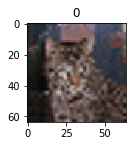

In [3]:
# Reading the dataset

def read_images_classes(basepath,imgSize=img_size):
    image_stack = []
    label_stack = []

    for counter, l in enumerate(labels):
        path = os.path.join(basepath, l,'*g')
        for img in glob.glob(path):
            one_hot_vector =np.zeros(len(labels),dtype=np.int16)
            one_hot_vector[counter]=1
            image = cv2.imread(img)
            im_resize = cv2.resize(image,img_shape, interpolation=cv2.INTER_CUBIC)
            image_stack.append(im_resize)
            label_stack.append(labels[l])            
    return np.array(image_stack), np.array(label_stack)

X_train, y_train=read_images_classes(trainpath)
X_test, y_test=read_images_classes(testpath)

#test a sample image
print('length of train image set',len(X_train))
print('X_data shape:', X_train.shape)
print('y_data shape:', y_train.shape)

fig1 = plt.figure() 
ax1 = fig1.add_subplot(2,2,1) 
img = cv2.resize(X_train[0],(64,64), interpolation=cv2.INTER_CUBIC)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(y_train[0])
plt.show()

In [4]:
def cnn_model_fn(features, labels, mode):
    
    #Input Layer
    
    input_layer = tf.reshape(features['x'],[-1,img_size,img_size,num_channels])
    
    
    # Covolution Layer 1
    
    conv_layer1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5,5],padding = "same",activation = tf.nn.relu)
    
    
    # Pooling Layer 1
    
    pool_layer1 = tf.layers.max_pooling2d(inputs = conv_layer1,pool_size=[2,2],strides=2)
    
    
    # Covolution Layer 2
    
    conv_layer2 = tf.layers.conv2d(inputs=pool_layer1,filters=64,kernel_size=[5,5],padding="same",activation=tf.nn.relu)
    
    # Pooling layer 2
    
    pool_layer2 = tf.layers.max_pooling2d(inputs=conv_layer2,pool_size=[2,2],strides=2)
    
    #Flatten Pool 2
    pool2Output_shape = pool_layer2.get_shape()
    num_features_pool2 = pool2Output_shape[1:4].num_elements()
    
    print(f"pool 2 output number of features is : {num_features_pool2}")
    
    pool_flat = tf.reshape(pool_layer2,shape=[-1,num_features_pool2])
    
    # Fully connected Layer
    
    fc_layer = tf.layers.dense(inputs=pool_flat,units=fc_size,activation=tf.nn.relu)
    
    #Dropout Layer
    
    dropout_layer = tf.layers.dropout(inputs=fc_layer,rate=0.4,training=mode==tf.estimator.ModeKeys.TRAIN)
    
    
    #logits layer
    
    logits=tf.layers.dense(inputs=dropout_layer,units=2)
    
    
    #eval,train
    
    predictions = {"classes":tf.argmax(input=logits,axis=1),"probabilities":tf.nn.softmax(logits,name="softmax_tensor")}
    
    
    # if the mode is to predict
    
    if mode==tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode,predictions=predictions)
    
    # if the mode is for training or eval
    
    onehotlabels = tf.one_hot(indices=tf.cast(labels,tf.int32),depth=2)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=onehotlabels,logits=logits)
    
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(loss,global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode,loss=loss,train_op=train_op)
    
        
    
    eval_metric_ops={"accuracy":tf.metrics.accuracy(labels-labels,predictions=predictions['classes'])}
    return tf.estimator.EstimatorSpec(mode=mode,loss=loss,eval_metric_ops=eval_metric_ops)



    
    
    
    
    
    
    

## Running the model

In [5]:
X_train = np.array((X_train/255.0),dtype=np.float32)
X_test = np.array((X_test/255.0), dtype=np.float32)

pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="/tmp/pets_convnet_model")
#pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn)
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_train}, y=y_train, batch_size=10,
                                                      num_epochs=None, shuffle=True)
pets_classifier.train(input_fn=train_input_fn, steps=num_steps, hooks=[logging_hook])
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_test}, y=y_test, num_epochs=1,shuffle=False)
eval_results = pets_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/pets_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001AF2B048898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/pets_convnet_model\model.ckpt-6800
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 6800 into /tmp/pets_convnet_model\model.ckpt.
INFO:tensorflow:probabilities = [[0.933164   0.06683595]
 [0.88066304 0.11933696]
 [0.41411754 0.5858825 ]
 [0.9475471  0.05245284]
 [0.7455015  0.25449854]
 [0.7939017  0.20609829]
 [0.00070028 0.99929965]
 [0.5388308  0.4611692 ]
 [0.9849471  0.0150529 ]
 [0.40370932 0.5962906 ]]
INFO:tensorfl

INFO:tensorflow:probabilities = [[0.9999927  0.00000726]
 [0.9998306  0.00016939]
 [0.99998736 0.00001266]
 [0.00018208 0.9998179 ]
 [0.98436385 0.01563615]
 [0.9989219  0.0010782 ]
 [0.99892443 0.00107556]
 [0.999814   0.0001861 ]
 [0.9989749  0.00102508]
 [0.07246907 0.9275309 ]] (1.870 sec)
INFO:tensorflow:global_step/sec: 26.2256
INFO:tensorflow:probabilities = [[0.9999999  0.00000015]
 [0.01298235 0.9870177 ]
 [0.9996574  0.00034264]
 [0.99999905 0.00000095]
 [0.00031295 0.9996871 ]
 [0.9981553  0.00184471]
 [0.00234676 0.9976533 ]
 [0.99633443 0.00366554]
 [0.00059135 0.9994086 ]
 [0.9989766  0.00102339]] (1.933 sec)
INFO:tensorflow:loss = 0.0023207758, step = 7501 (3.807 sec)
INFO:tensorflow:probabilities = [[0.9979564  0.00204354]
 [0.00208564 0.9979144 ]
 [0.00061068 0.9993893 ]
 [0.99947375 0.00052624]
 [0.91591877 0.08408117]
 [0.9999063  0.00009363]
 [0.00288788 0.99711215]
 [0.00005522 0.9999448 ]
 [0.00109787 0.9989021 ]
 [0.9999969  0.00000305]] (2.090 sec)
INFO:tensorfl

INFO:tensorflow:loss = 0.003364979, step = 8601 (4.068 sec)
INFO:tensorflow:probabilities = [[0.00001257 0.9999875 ]
 [0.99903166 0.0009683 ]
 [0.9955178  0.00448225]
 [0.05433078 0.94566923]
 [0.00000804 0.999992  ]
 [0.00000631 0.9999937 ]
 [0.9999999  0.00000017]
 [0.9999999  0.00000007]
 [0.00001649 0.99998355]
 [0.00000025 0.99999976]] (1.860 sec)
INFO:tensorflow:global_step/sec: 26.6426
INFO:tensorflow:probabilities = [[0.00202284 0.9979772 ]
 [0.99999964 0.00000034]
 [0.00082265 0.9991773 ]
 [0.00062821 0.9993718 ]
 [0.00001729 0.9999827 ]
 [0.00031237 0.9996877 ]
 [1.         0.        ]
 [0.9998479  0.00015207]
 [0.01196592 0.98803407]
 [0.00000421 0.9999958 ]] (1.894 sec)
INFO:tensorflow:loss = 0.001600069, step = 8701 (3.750 sec)
INFO:tensorflow:probabilities = [[0.9999819  0.00001807]
 [0.00075723 0.9992428 ]
 [0.03401522 0.96598476]
 [1.         0.        ]
 [0.99995804 0.00004197]
 [0.00106915 0.9989309 ]
 [0.9996623  0.00033777]
 [0.00028524 0.9997148 ]
 [0.00005345 0.99

INFO:tensorflow:loss = 0.011979148, step = 9801 (4.593 sec)
INFO:tensorflow:probabilities = [[0.00000511 0.9999949 ]
 [0.00001938 0.99998057]
 [0.99994266 0.00005736]
 [0.0000001  0.9999999 ]
 [0.00000865 0.9999913 ]
 [1.         0.00000002]
 [0.9998348  0.00016516]
 [0.00000642 0.99999356]
 [0.00000026 0.99999976]
 [0.00003212 0.99996793]] (2.081 sec)
INFO:tensorflow:global_step/sec: 22.16
INFO:tensorflow:probabilities = [[0.91870105 0.08129892]
 [0.99999475 0.00000528]
 [1.         0.00000002]
 [1.         0.        ]
 [0.99999785 0.00000213]
 [0.9999999  0.00000008]
 [0.00000001 1.        ]
 [0.9999919  0.00000808]
 [0.00000399 0.99999607]
 [0.99999845 0.00000154]] (2.379 sec)
INFO:tensorflow:loss = 0.008481559, step = 9901 (4.464 sec)
INFO:tensorflow:probabilities = [[0.         1.        ]
 [1.         0.        ]
 [0.0000071  0.99999285]
 [0.99999964 0.00000032]
 [0.00000001 1.        ]
 [0.00000449 0.99999547]
 [0.9999976  0.00000236]
 [1.         0.        ]
 [0.99442506 0.0055

INFO:tensorflow:loss = 6.0001643e-05, step = 11001 (8.044 sec)
INFO:tensorflow:probabilities = [[0.00015225 0.99984777]
 [0.97893494 0.02106501]
 [0.00002578 0.99997425]
 [0.9999982  0.00000183]
 [0.00000815 0.9999919 ]
 [1.         0.        ]
 [0.16589332 0.83410674]
 [0.00000216 0.99999785]
 [0.999985   0.00001506]
 [0.04692723 0.9530727 ]] (3.813 sec)
INFO:tensorflow:global_step/sec: 13.1051
INFO:tensorflow:probabilities = [[0.98925424 0.01074574]
 [0.00000414 0.9999958 ]
 [0.         1.        ]
 [0.00000014 0.9999999 ]
 [1.         0.        ]
 [0.02488823 0.9751118 ]
 [0.00822784 0.9917721 ]
 [0.9999161  0.0000839 ]
 [0.0000013  0.9999987 ]
 [1.         0.00000001]] (3.822 sec)
INFO:tensorflow:loss = 0.004435847, step = 11101 (7.631 sec)
INFO:tensorflow:probabilities = [[0.99884146 0.00115852]
 [0.00000025 0.99999976]
 [0.9998739  0.00012611]
 [0.99640524 0.00359475]
 [0.99771154 0.0022884 ]
 [0.9999999  0.00000009]
 [0.99822503 0.00177501]
 [0.99999976 0.00000021]
 [0.99992096 

INFO:tensorflow:loss = 1.1109919e-05, step = 12201 (8.444 sec)
INFO:tensorflow:probabilities = [[0.00000134 0.9999987 ]
 [0.00023745 0.9997626 ]
 [1.         0.        ]
 [0.00001233 0.9999877 ]
 [1.         0.00000001]
 [0.00002958 0.99997044]
 [0.00000028 0.99999976]
 [0.00000006 0.9999999 ]
 [0.99999976 0.00000029]
 [1.         0.        ]] (4.239 sec)
INFO:tensorflow:global_step/sec: 11.7881
INFO:tensorflow:probabilities = [[0.9999995  0.00000051]
 [0.99996626 0.00003378]
 [0.00000242 0.9999976 ]
 [1.         0.        ]
 [1.         0.00000001]
 [0.9988003  0.00119976]
 [1.         0.        ]
 [0.9724419  0.02755807]
 [0.00003967 0.9999603 ]
 [0.00156711 0.99843293]] (4.245 sec)
INFO:tensorflow:loss = 0.003078991, step = 12301 (8.484 sec)
INFO:tensorflow:probabilities = [[0.00000117 0.9999988 ]
 [1.         0.00000002]
 [1.         0.        ]
 [0.00000001 1.        ]
 [0.9999999  0.00000009]
 [0.00000468 0.99999535]
 [0.00458187 0.9954182 ]
 [1.         0.        ]
 [1.         

INFO:tensorflow:loss = 2.5520683e-05, step = 13401 (7.583 sec)
INFO:tensorflow:probabilities = [[1.         0.00000001]
 [0.01186958 0.98813045]
 [0.99982136 0.00017872]
 [1.         0.        ]
 [0.9999999  0.00000013]
 [0.0000334  0.9999666 ]
 [0.00006101 0.99993896]
 [0.00000077 0.9999993 ]
 [1.         0.        ]
 [0.9992818  0.00071823]] (3.679 sec)
INFO:tensorflow:global_step/sec: 13.4459
INFO:tensorflow:probabilities = [[0.         1.        ]
 [0.99999297 0.00000703]
 [0.01327286 0.98672706]
 [1.         0.        ]
 [0.9999988  0.00000122]
 [1.         0.00000003]
 [1.         0.        ]
 [0.0000011  0.9999989 ]
 [0.00018881 0.99981123]
 [1.         0.        ]] (3.751 sec)
INFO:tensorflow:loss = 0.0013559897, step = 13501 (7.435 sec)
INFO:tensorflow:probabilities = [[0.99999464 0.00000541]
 [0.00025403 0.9997459 ]
 [0.00118741 0.99881256]
 [0.00000002 1.        ]
 [0.00001391 0.99998605]
 [0.00004077 0.99995923]
 [0.00000006 1.        ]
 [0.00189892 0.99810106]
 [0.00000199

INFO:tensorflow:loss = 1.7713854e-05, step = 14601 (7.719 sec)
INFO:tensorflow:probabilities = [[0.00000389 0.99999607]
 [0.00000013 0.9999999 ]
 [0.         1.        ]
 [1.         0.00000002]
 [0.00027734 0.99972266]
 [0.99963105 0.00036888]
 [0.99991965 0.00008038]
 [0.00022981 0.9997702 ]
 [0.00000067 0.9999993 ]
 [0.00000001 1.        ]] (4.167 sec)
INFO:tensorflow:global_step/sec: 12.8011
INFO:tensorflow:probabilities = [[0.00030876 0.99969125]
 [0.00000339 0.99999666]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.000014   0.99998605]
 [0.9981931  0.00180697]
 [0.00005397 0.999946  ]
 [0.9955076  0.00449245]
 [0.99999976 0.00000022]] (3.650 sec)
INFO:tensorflow:loss = 0.00066914206, step = 14701 (7.822 sec)
INFO:tensorflow:probabilities = [[1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [1.         0.00000001]
 [0.9999769  0.00002317]
 [0.00176828 0.9982317 ]
 [1.         0.        ]
 [1.         0.00000002]
 [1.       

INFO:tensorflow:loss = 1.4161547e-05, step = 15801 (8.191 sec)
INFO:tensorflow:probabilities = [[0.00045687 0.9995432 ]
 [0.00002015 0.99997985]
 [0.00000325 0.9999968 ]
 [0.9999739  0.00002606]
 [0.9999995  0.00000047]
 [1.         0.        ]
 [0.         1.        ]
 [0.00001389 0.99998605]
 [1.         0.        ]
 [0.00000028 0.99999976]] (3.901 sec)
INFO:tensorflow:Saving checkpoints for 15892 into /tmp/pets_convnet_model\model.ckpt.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
INFO:tensorflow:global_step/sec: 12.3168
INFO:tensorflow:probabilities = [[1.         0.00000001]
 [0.00001647 0.99998355]
 [0.09510674 0.9048932 ]
 [1.         0.        ]
 [0.99999976 0.0000003 ]
 [0.         1.        ]
 [0.9999956  0.00000442]
 [0.00000001 1.        ]
 [0.00000008 0.9999999 ]
 [0.00000058 0.9999994 ]] (4.217 sec)
INFO:tensorflow:loss = 0.0099960165, step = 15901 (8.118 sec)
INFO:tensorflow:probabilities = [[0.00001651 0.99998355]
 [1.         0.  

INFO:tensorflow:global_step/sec: 12.5518
INFO:tensorflow:probabilities = [[0.9997366  0.00026339]
 [0.00002198 0.99997807]
 [0.99999106 0.00000892]
 [1.         0.00000003]
 [0.95857394 0.04142611]
 [0.0014874  0.99851257]
 [0.00000832 0.99999166]
 [0.00000005 1.        ]
 [0.00000006 0.9999999 ]
 [1.         0.        ]] (4.133 sec)
INFO:tensorflow:loss = 0.004409987, step = 17001 (7.971 sec)
INFO:tensorflow:probabilities = [[0.00000005 1.        ]
 [0.99998736 0.00001265]
 [0.9999031  0.00009686]
 [0.00003552 0.9999645 ]
 [0.00279061 0.99720937]
 [0.001823   0.99817705]
 [1.         0.        ]
 [0.00001532 0.9999846 ]
 [0.9998853  0.00011468]
 [0.9999969  0.00000314]] (4.029 sec)
INFO:tensorflow:global_step/sec: 12.7453
INFO:tensorflow:probabilities = [[0.00000001 1.        ]
 [0.9999956  0.00000436]
 [0.         1.        ]
 [0.9999987  0.00000137]
 [1.         0.00000002]
 [0.98151934 0.01848071]
 [1.         0.        ]
 [0.00000088 0.99999917]
 [0.9999999  0.00000015]
 [1.      

INFO:tensorflow:global_step/sec: 10.1776
INFO:tensorflow:probabilities = [[0.99999714 0.00000282]
 [0.00000014 0.9999999 ]
 [0.00000007 0.9999999 ]
 [0.9999999  0.00000008]
 [0.00000975 0.9999902 ]
 [0.00000009 0.9999999 ]
 [0.00000001 1.        ]
 [0.00000001 1.        ]
 [0.00000005 1.        ]
 [0.         1.        ]] (4.567 sec)
INFO:tensorflow:loss = 1.311297e-06, step = 18201 (9.826 sec)
INFO:tensorflow:probabilities = [[0.         1.        ]
 [0.         1.        ]
 [0.00000003 1.        ]
 [0.         1.        ]
 [1.         0.        ]
 [0.99636614 0.00363378]
 [0.00013991 0.99986005]
 [0.9999999  0.00000015]
 [0.99999726 0.0000028 ]
 [1.         0.        ]] (4.186 sec)
INFO:tensorflow:global_step/sec: 12.7553
INFO:tensorflow:probabilities = [[0.99999917 0.00000079]
 [0.00043554 0.99956447]
 [0.00000665 0.9999933 ]
 [0.00015636 0.9998436 ]
 [0.0000103  0.99998975]
 [0.99999964 0.00000031]
 [1.         0.        ]
 [0.00000008 0.9999999 ]
 [1.         0.        ]
 [0.00000

INFO:tensorflow:global_step/sec: 11.7019
INFO:tensorflow:probabilities = [[1.         0.        ]
 [0.99999905 0.00000091]
 [1.         0.00000001]
 [0.00011231 0.9998877 ]
 [0.         1.        ]
 [1.         0.00000001]
 [0.         1.        ]
 [0.9999999  0.00000009]
 [1.         0.00000004]
 [0.99999976 0.00000029]] (4.077 sec)
INFO:tensorflow:loss = 1.13600145e-05, step = 19401 (8.551 sec)
INFO:tensorflow:probabilities = [[1.         0.        ]
 [0.00000013 0.9999999 ]
 [1.         0.        ]
 [0.99999785 0.0000021 ]
 [0.999998   0.00000199]
 [0.00443084 0.99556917]
 [0.         1.        ]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]] (4.284 sec)
INFO:tensorflow:global_step/sec: 12.1247
INFO:tensorflow:probabilities = [[1.         0.        ]
 [0.00008532 0.99991465]
 [0.00000002 1.        ]
 [0.00877971 0.9912203 ]
 [0.         1.        ]
 [0.9999999  0.00000017]
 [0.9999999  0.00000016]
 [0.00000077 0.9999993 ]
 [1.         0.        ]
 [1.   

INFO:tensorflow:global_step/sec: 12.1391
INFO:tensorflow:probabilities = [[0.00002284 0.9999771 ]
 [0.00000121 0.9999988 ]
 [0.         1.        ]
 [0.9999813  0.00001871]
 [0.9999999  0.00000016]
 [1.         0.        ]
 [0.9999982  0.00000175]
 [0.00000016 0.9999999 ]
 [1.         0.        ]
 [1.         0.        ]] (4.290 sec)
INFO:tensorflow:loss = 4.4822254e-06, step = 20601 (8.226 sec)
INFO:tensorflow:probabilities = [[0.00000001 1.        ]
 [1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [0.00000021 0.99999976]
 [0.00000012 0.9999999 ]
 [0.00001308 0.9999869 ]
 [0.         1.        ]
 [1.         0.        ]
 [0.         1.        ]] (4.170 sec)
INFO:tensorflow:global_step/sec: 12.2372
INFO:tensorflow:probabilities = [[0.99999964 0.00000036]
 [0.00001947 0.99998057]
 [0.00000001 1.        ]
 [0.00000001 1.        ]
 [0.00152481 0.99847513]
 [0.00000038 0.99999964]
 [1.         0.        ]
 [1.         0.        ]
 [0.00000586 0.99999416]
 [0.    

INFO:tensorflow:Saving checkpoints for 21800 into /tmp/pets_convnet_model\model.ckpt.
INFO:tensorflow:Loss for final step: 8.702265e-07.
INFO:tensorflow:Calling model_fn.
pool 2 output number of features is : 4096
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-10-12T23:16:19Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/pets_convnet_model\model.ckpt-21800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-10-12-23:16:20
INFO:tensorflow:Saving dict for global step 21800: accuracy = 0.6, global_step = 21800, loss = 4.423813
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 21800: /tmp/pets_convnet_model\model.ckpt-21800
{'accuracy': 0.6, 'loss': 4.423813, 'global_step': 21800}


### So the acuracy came out be 0.6 after 15000 epochs.